In [6]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

In [7]:
weather_df = pd.read_csv('C:/Users/paulh/Desktop/Domäneprojekt2/Energy_production_price_prediction/weather_data/DWD_ICON-EU.csv')
solar_total = pd.read_csv('C:/Users/paulh/Desktop/Domäneprojekt2/Energy_production_price_prediction/basic_files/solar_total_production.csv')

In [8]:
weather_df.sort_values(by='ref_datetime', inplace=True)

In [9]:
weather_df = weather_df.groupby(["valid_datetime","latitude","longitude"]).last().reset_index()

In [10]:
print(weather_df.columns)

Index(['valid_datetime', 'latitude', 'longitude', 'ref_datetime',
       'Temperature', 'WindSpeed', 'WindSpeed:100', 'WindDirection:100',
       'CloudCover', 'RelativeHumidity', 'PressureReducedMSL',
       'SolarDownwardRadiation', 'TotalPrecipitation'],
      dtype='object')


In [11]:
weather_df.reset_index(inplace=True)

In [12]:
def resample_and_interpolate(group):
    return group.reset_index(level=[1, 2]).resample('30T').asfreq().interpolate()

In [13]:
weather_df.valid_datetime = pd.to_datetime(weather_df.valid_datetime)
weather_df = weather_df.set_index(["valid_datetime","latitude","longitude"])
df_resampled = weather_df.groupby(['latitude', 'longitude'], group_keys=False).apply(resample_and_interpolate)

C:\Users\paulh\AppData\Local\Temp\ipykernel_8284\2834871732.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  return group.reset_index(level=[1, 2]).resample('30T').asfreq().interpolate()
C:\Users\paulh\AppData\Local\Temp\ipykernel_8284\2834871732.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  return group.reset_index(level=[1, 2]).resample('30T').asfreq().interpolate()
C:\Users\paulh\AppData\Local\Temp\ipykernel_8284\2834871732.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  return group.reset_index(level=[1, 2]).resample('30T').asfreq().interpolate()
C:\Users\paulh\AppData\Local\Temp\ipykernel_8284\283

In [14]:
df_resampled = df_resampled.reset_index()

In [15]:
solar_total.timestamp_utc = pd.to_datetime(solar_total.timestamp_utc)

In [16]:
df_resampled.drop(columns=['index','ref_datetime'], inplace=True)

In [17]:
# df_resampled = df_resampled.groupby("valid_datetime").mean().reset_index()

In [18]:
df_resampled_merged = pd.merge(df_resampled, solar_total, how='left', left_on='valid_datetime', right_on='timestamp_utc')

In [19]:
df_resampled_merged.columns

Index(['valid_datetime', 'latitude', 'longitude', 'Temperature', 'WindSpeed',
       'WindSpeed:100', 'WindDirection:100', 'CloudCover', 'RelativeHumidity',
       'PressureReducedMSL', 'SolarDownwardRadiation', 'TotalPrecipitation',
       'timestamp_utc', 'generation_mw', 'installed_capacity_mwp',
       'capacity_mwp'],
      dtype='object')

solar

In [20]:
df_resampled_merged_solar = df_resampled_merged.loc[~(df_resampled_merged.latitude == 53.935) & ~(df_resampled_merged.longitude == 1.8645)]

In [21]:
df_resampled_merged_solar1 = df_resampled_merged_solar.groupby("valid_datetime").mean().reset_index()

In [22]:
df_resampled_merged_solar1.columns

Index(['valid_datetime', 'latitude', 'longitude', 'Temperature', 'WindSpeed',
       'WindSpeed:100', 'WindDirection:100', 'CloudCover', 'RelativeHumidity',
       'PressureReducedMSL', 'SolarDownwardRadiation', 'TotalPrecipitation',
       'timestamp_utc', 'generation_mw', 'installed_capacity_mwp',
       'capacity_mwp'],
      dtype='object')

In [23]:
def set_up_solar_features(df):
    df["hour"] = df.valid_datetime.dt.hour
    df["day_of_year"] = df.valid_datetime.dt.dayofyear
    df["cos_day_of_year"] = np.cos(2 * np.pi * df.day_of_year / 365)
    df["cos_hour"] = np.cos(2 * np.pi * df.hour / 24)
    df["Mean_SolarDownwardRadiation"] = df.SolarDownwardRadiation
    df["Mean_Temperature"] = df.Temperature
    df["Std_Temperature"] = df_resampled_merged_solar.groupby("valid_datetime").std().reset_index().Temperature
    df["SolarDownwardRadiation_RW_Mean_30min"] = df.Mean_SolarDownwardRadiation.rolling(window=1, min_periods=1).mean()
    df["SolarDownwardRadiation_RW_Mean_1hour"] = df.Mean_SolarDownwardRadiation.rolling(window=2, min_periods=1).mean()
    df["SolarDownwardRadiation_dwd_Mean_Lag_30min"] = df.Mean_SolarDownwardRadiation.shift(1)
    df["SolarDownwardRadiation_dwd_Mean_Lag_1h"] = df.Mean_SolarDownwardRadiation.shift(2)
    df["SolarDownwardRadiation_dwd_Mean_Lag_24h"] = df.Mean_SolarDownwardRadiation.shift(48)
    return df

In [24]:
df_resampled_merged_solar2 = set_up_solar_features(df_resampled_merged_solar1)

In [25]:
df_resampled_merged_solar2

,valid_datetime,latitude,longitude,Temperature,WindSpeed,WindSpeed:100,WindDirection:100,CloudCover,RelativeHumidity,PressureReducedMSL,...,cos_day_of_year,cos_hour,Mean_SolarDownwardRadiation,Mean_Temperature,Std_Temperature,SolarDownwardRadiation_RW_Mean_30min,SolarDownwardRadiation_RW_Mean_1hour,SolarDownwardRadiation_dwd_Mean_Lag_30min,SolarDownwardRadiation_dwd_Mean_Lag_1h,SolarDownwardRadiation_dwd_Mean_Lag_24h
0,2024-10-07 00:00:00+00:00,52.381681,0.650333,14.127000,4.818000,8.369000,226.312500,0.89300,93.61300,99466.753500,...,0.124479,1.000000,0.000,14.127000,0.424575,0.000,0.000,NaN,NaN,NaN
1,2024-10-07 00:30:00+00:00,52.381681,0.650333,13.962250,4.939500,8.518500,232.540250,0.89825,92.78875,99514.004250,...,0.124479,1.000000,0.000,13.962250,0.439088,0.000,0.000,0.000,NaN,NaN
2,2024-10-07 01:00:00+00:00,52.381681,0.650333,13.797500,5.061000,8.668000,238.768000,0.90350,91.96450,99561.255000,...,0.124479,0.965926,0.000,13.797500,0.464677,0.000,0.000,0.000,0.000,NaN
3,2024-10-07 01:30:00+00:00,52.381681,0.650333,13.537000,5.072250,8.706500,239.918500,0.86175,91.31550,99557.524500,...,0.124479,0.965926,0.000,13.537000,0.514471,0.000,0.000,0.000,0.000,NaN
4,2024-10-07 02:00:00+00:00,52.381681,0.650333,13.276500,5.083500,8.745000,241.069000,0.82000,90.66650,99553.794000,...,0.124479,0.866025,0.000,13.276500,0.595874,0.000,0.000,0.000,0.000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,2024-10-13 22:00:00+00:00,52.381681,0.650333,6.527667,1.508833,4.512667,100.241833,0.99300,77.36050,102366.897333,...,0.226116,0.866025,1.259,6.527667,0.522128,1.259,1.259,1.259,1.259,1.647667
333,2024-10-13 22:30:00+00:00,52.381681,0.650333,6.492000,1.537500,4.577500,101.914250,0.99475,77.39000,102362.286500,...,0.226116,0.866025,1.259,6.492000,0.519918,1.259,1.259,1.259,1.259,1.565250
334,2024-10-13 23:00:00+00:00,52.381681,0.650333,6.456333,1.566167,4.642333,103.586667,0.99650,77.41950,102357.675667,...,0.226116,0.965926,1.259,6.456333,0.520902,1.259,1.259,1.259,1.259,1.482833
335,2024-10-13 23:30:00+00:00,52.381681,0.650333,6.420667,1.594833,4.707167,105.259083,0.99825,77.44900,102353.064833,...,0.226116,0.965926,1.259,6.420667,0.525064,1.259,1.259,1.259,1.259,1.400417


In [26]:
def pv_temperature_efficiency(irradiance, ambient_temp, NOCT=45, wind_speed=1, eta_0=0.18, beta=0.004):
    # Calculate cell temperature using the simplified NOCT model
    Tc = ambient_temp + (NOCT - 20) * (irradiance / 800)
    
    # Calculate the efficiency loss due to increased cell temperature
    efficiency = eta_0 * (1 - beta * (Tc - 25))
    
    return Tc, efficiency

In [27]:
df_resampled_merged_solar2["Panel_Temperature_dwd_mean"], df_resampled_merged_solar2["Panel_Efficiency_dwd_mean"] = pv_temperature_efficiency(df_resampled_merged_solar2["Mean_SolarDownwardRadiation"], df_resampled_merged_solar2["Mean_Temperature"])

In [28]:
df_resampled_merged_solar2["Panel_Temperature_dwd_std"] = df_resampled_merged_solar2.Panel_Temperature_dwd_mean.std()
df_resampled_merged_solar2["Panel_Efficiency_dwd_std"] = df_resampled_merged_solar2.Panel_Efficiency_dwd_mean.std()

In [29]:
df_resampled_merged_solar2

,valid_datetime,latitude,longitude,Temperature,WindSpeed,WindSpeed:100,WindDirection:100,CloudCover,RelativeHumidity,PressureReducedMSL,...,Std_Temperature,SolarDownwardRadiation_RW_Mean_30min,SolarDownwardRadiation_RW_Mean_1hour,SolarDownwardRadiation_dwd_Mean_Lag_30min,SolarDownwardRadiation_dwd_Mean_Lag_1h,SolarDownwardRadiation_dwd_Mean_Lag_24h,Panel_Temperature_dwd_mean,Panel_Efficiency_dwd_mean,Panel_Temperature_dwd_std,Panel_Efficiency_dwd_std
0,2024-10-07 00:00:00+00:00,52.381681,0.650333,14.127000,4.818000,8.369000,226.312500,0.89300,93.61300,99466.753500,...,0.424575,0.000,0.000,NaN,NaN,NaN,14.127000,0.187829,5.732612,0.004127
1,2024-10-07 00:30:00+00:00,52.381681,0.650333,13.962250,4.939500,8.518500,232.540250,0.89825,92.78875,99514.004250,...,0.439088,0.000,0.000,0.000,NaN,NaN,13.962250,0.187947,5.732612,0.004127
2,2024-10-07 01:00:00+00:00,52.381681,0.650333,13.797500,5.061000,8.668000,238.768000,0.90350,91.96450,99561.255000,...,0.464677,0.000,0.000,0.000,0.000,NaN,13.797500,0.188066,5.732612,0.004127
3,2024-10-07 01:30:00+00:00,52.381681,0.650333,13.537000,5.072250,8.706500,239.918500,0.86175,91.31550,99557.524500,...,0.514471,0.000,0.000,0.000,0.000,NaN,13.537000,0.188253,5.732612,0.004127
4,2024-10-07 02:00:00+00:00,52.381681,0.650333,13.276500,5.083500,8.745000,241.069000,0.82000,90.66650,99553.794000,...,0.595874,0.000,0.000,0.000,0.000,NaN,13.276500,0.188441,5.732612,0.004127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,2024-10-13 22:00:00+00:00,52.381681,0.650333,6.527667,1.508833,4.512667,100.241833,0.99300,77.36050,102366.897333,...,0.522128,1.259,1.259,1.259,1.259,1.647667,6.567010,0.193272,5.732612,0.004127
333,2024-10-13 22:30:00+00:00,52.381681,0.650333,6.492000,1.537500,4.577500,101.914250,0.99475,77.39000,102362.286500,...,0.519918,1.259,1.259,1.259,1.259,1.565250,6.531344,0.193297,5.732612,0.004127
334,2024-10-13 23:00:00+00:00,52.381681,0.650333,6.456333,1.566167,4.642333,103.586667,0.99650,77.41950,102357.675667,...,0.520902,1.259,1.259,1.259,1.259,1.482833,6.495677,0.193323,5.732612,0.004127
335,2024-10-13 23:30:00+00:00,52.381681,0.650333,6.420667,1.594833,4.707167,105.259083,0.99825,77.44900,102353.064833,...,0.525064,1.259,1.259,1.259,1.259,1.400417,6.460010,0.193349,5.732612,0.004127


In [156]:
df_resampled_merged_solar1.generation_mw.to_clipboard()

In [26]:
df_resampled_merged_solar2.generation_mw.shift(periods= 48).to_clipboard()

In [30]:
df_resampled_merged_solar2["solar_mw_lag_24h"] = df_resampled_merged_solar2.generation_mw.shift(periods= 48)

In [31]:
df_resampled_merged_solar3 = df_resampled_merged_solar2[[ 
    "Mean_SolarDownwardRadiation",
    "SolarDownwardRadiation_RW_Mean_30min",
    "SolarDownwardRadiation_RW_Mean_1hour",
    "SolarDownwardRadiation_dwd_Mean_Lag_30min",
    "SolarDownwardRadiation_dwd_Mean_Lag_1h",
    "SolarDownwardRadiation_dwd_Mean_Lag_24h",
    "Panel_Efficiency_dwd_mean",
    "Panel_Efficiency_dwd_std",
    "Panel_Temperature_dwd_mean",
    "Panel_Temperature_dwd_std",
    "Std_Temperature",
    "Mean_Temperature",
    "cos_hour",
    "cos_day_of_year","solar_mw_lag_24h","generation_mw"]]

In [32]:
df_resampled_merged_solar3.dropna(inplace=True)

C:\Users\paulh\AppData\Local\Temp\ipykernel_8284\2037698839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_merged_solar3.dropna(inplace=True)


In [33]:
df_resampled_merged_solar3

,Mean_SolarDownwardRadiation,SolarDownwardRadiation_RW_Mean_30min,SolarDownwardRadiation_RW_Mean_1hour,SolarDownwardRadiation_dwd_Mean_Lag_30min,SolarDownwardRadiation_dwd_Mean_Lag_1h,SolarDownwardRadiation_dwd_Mean_Lag_24h,Panel_Efficiency_dwd_mean,Panel_Efficiency_dwd_std,Panel_Temperature_dwd_mean,Panel_Temperature_dwd_std,Std_Temperature,Mean_Temperature,cos_hour,cos_day_of_year,solar_mw_lag_24h,generation_mw
48,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.188265,0.004127,13.520500,5.732612,0.555636,13.52050,1.000000e+00,0.141540,0.000000,0.000000
49,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.188252,0.004127,13.539250,5.732612,0.526445,13.53925,1.000000e+00,0.141540,0.000000,0.000000
50,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.188238,0.004127,13.558000,5.732612,0.517612,13.55800,9.659258e-01,0.141540,0.000000,0.000000
51,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.188266,0.004127,13.519000,5.732612,0.505375,13.51900,9.659258e-01,0.141540,0.000000,0.000000
52,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.188294,0.004127,13.480000,5.732612,0.490222,13.48000,8.660254e-01,0.141540,0.000000,0.000000
53,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.188339,0.004127,13.418500,5.732612,0.471828,13.41850,8.660254e-01,0.141540,0.000000,0.000000
54,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.188383,0.004127,13.357000,5.732612,0.456417,13.35700,7.071068e-01,0.141540,0.000000,0.000000
55,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.188406,0.004127,13.325250,5.732612,0.442051,13.32525,7.071068e-01,0.141540,0.000000,0.000000
56,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.188429,0.004127,13.293500,5.732612,0.432657,13.29350,5.000000e-01,0.141540,0.000000,0.000000
57,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.188497,0.004127,13.198750,5.732612,0.407895,13.19875,5.000000e-01,0.141540,0.000000,0.000000


In [34]:
#load scaler and model
import pickle
from sklearn.preprocessing import StandardScaler

scaler = pickle.load(open('C:/Users/paulh/Desktop/Domäneprojekt2/Energy_production_price_prediction/paul_analyse/scaler.pkl', 'rb'))
X = df_resampled_merged_solar3.drop(columns=["generation_mw"])
X_scaled = scaler.transform(X)
Y = df_resampled_merged_solar3.generation_mw

c:\Users\paulh\anaconda3\envs\HEFTcom24\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [35]:
X_scaled

array([[-6.56075325e-01, -6.56075325e-01, -6.57892236e-01,
        -6.55965305e-01, -6.56267935e-01, -6.56371021e-01,
         3.06424887e-02,  7.29026299e+00, -3.06424887e-02,
         7.29026299e+00, -1.23358644e-01,  4.84956645e-01,
         1.41514795e+00,  1.84906565e-01, -6.17967088e-01],
       [-6.56075325e-01, -6.56075325e-01, -6.57892236e-01,
        -6.55965305e-01, -6.56267935e-01, -6.56371021e-01,
         2.86520015e-02,  7.29026299e+00, -2.86520015e-02,
         7.29026299e+00, -1.94075603e-01,  4.88061781e-01,
         1.41514795e+00,  1.84906565e-01, -6.17967088e-01],
       [-6.56075325e-01, -6.56075325e-01, -6.57892236e-01,
        -6.55965305e-01, -6.56267935e-01, -6.56371021e-01,
         2.66615144e-02,  7.29026299e+00, -2.66615144e-02,
         7.29026299e+00, -2.15474163e-01,  4.91166918e-01,
         1.36693883e+00,  1.84906565e-01, -6.17967088e-01],
       [-6.56075325e-01, -6.56075325e-01, -6.57892236e-01,
        -6.55965305e-01, -6.56267935e-01, -6.56371021

In [36]:
import torch
import torch.nn as nn

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 64)
        self.fc5 = nn.Linear(64, 9)

        self.dropout = nn.Dropout(0.2)
        self.swish = nn.SiLU()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.swish(self.fc2(x))
        x = self.dropout(x)
        x = self.swish(self.fc3(x))
        x = self.dropout(x)
        x = self.swish(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

In [37]:
# Load the model from the file
model = MLP(X_scaled.shape[1])
model.load_state_dict(torch.load('C:/Users/paulh/Desktop/Domäneprojekt2/Energy_production_price_prediction/paul_analyse/model.pth'))

C:\Users\paulh\AppData\Local\Temp\ipykernel_8284\3975033927.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('C:/Users/paulh/Desktop/Domä

<All keys matched successfully>

In [38]:
#make predictions
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
model.eval()
with torch.no_grad():
    predictions = model(X_tensor).numpy()

predictions

array([[-1.83351895e-05, -4.74634726e-05, -4.71437306e-05,
        -2.68727978e-04, -6.78474596e-03, -2.99350210e-02,
        -6.40965700e-02, -9.46754515e-02, -7.62423873e-02],
       [-1.83224438e-05, -4.72693937e-05, -4.68665239e-05,
        -2.67741794e-04, -6.75107865e-03, -2.97661982e-02,
        -6.36660308e-02, -9.38256383e-02, -7.48221874e-02],
       [-1.82201184e-05, -4.65845005e-05, -4.52769600e-05,
        -2.55128747e-04, -6.45251898e-03, -2.84374021e-02,
        -6.05450273e-02, -8.80391598e-02, -6.57883286e-02],
       [-1.82210078e-05, -4.65552075e-05, -4.52163076e-05,
        -2.54825485e-04, -6.44488400e-03, -2.84019746e-02,
        -6.04593456e-02, -8.78759921e-02, -6.55252934e-02],
       [-1.79198050e-05, -4.43635654e-05, -4.04596140e-05,
        -2.18313246e-04, -5.54587180e-03, -2.43437923e-02,
        -5.08251935e-02, -6.98717833e-02, -3.71767879e-02],
       [-1.79200233e-05, -4.43147437e-05, -4.03721060e-05,
        -2.17932917e-04, -5.53494738e-03, -2.429100

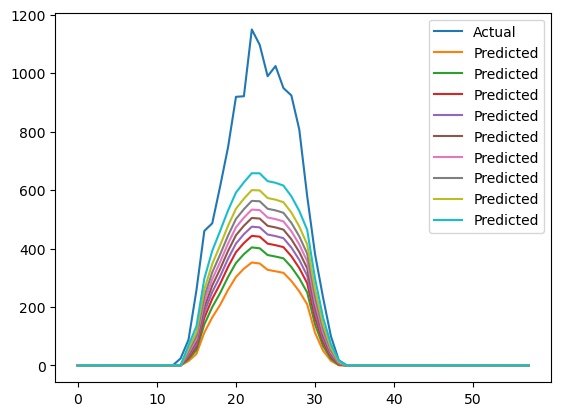

In [39]:
#compare predictions with actual values
import matplotlib.pyplot as plt

plt.plot(Y.values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()
